<a href="https://colab.research.google.com/github/vs74/EEG/blob/master/Notebooks/Conv-1D_keras_GoogleColab_forecasting_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
rng = np.random
from array import array
from scipy import stats

#Keras import 
import tensorflow.keras as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

#import models
#from Linear_Regression import linear_regression 

#import datetime for tensorboard
from datetime import *

#Import for reading the MATLAB files
import glob

#Preprocessing using scikit learn 
from sklearn.preprocessing import MinMaxScaler

In [154]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Copy the content from the drive folder to the root directory
!cp /content/drive/My\ Drive/EEG_data/1filtered.mat /content/

In [156]:
#Check the data is downloaded or not
!ls

1filtered.mat	ngrok-stable-linux-amd64.zip	ngrok-stable-linux-amd64.zip.5
drive		ngrok-stable-linux-amd64.zip.1	ngrok-stable-linux-amd64.zip.6
logs		ngrok-stable-linux-amd64.zip.2	ngrok-stable-linux-amd64.zip.7
model_plot.png	ngrok-stable-linux-amd64.zip.3	ngrok-stable-linux-amd64.zip.8
ngrok		ngrok-stable-linux-amd64.zip.4	sample_data


In [157]:
#Ensure Google COlab is utilising GPU 
tf.test.gpu_device_name()


'/device:GPU:0'

In [158]:

#Ensure that GPU memory utilisation is full
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 11.1 GB  | Proc size: 23.2 GB
GPU RAM Free: 12149MB | Used: 4131MB | Util  25% | Total 16280MB


In [159]:
'''!nvidia-smi
!kill 0
'''

'!nvidia-smi\n!kill 0\n'

In [160]:
#Visualize Using Tenosrboard
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2020-03-12 16:51:07--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.20.119.24, 52.206.56.146, 34.194.226.61, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.20.119.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.9’

ngrok-stable-linux- 100%[===================>]  13.13M  18.8MB/s    in 0.7s    

2020-03-12 16:51:08 (18.8 MB/s) - ‘ngrok-stable-linux-amd64.zip.9’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [161]:



# data import from matlab
subject_1 = sio.loadmat('1filtered.mat')      #recovering matlab data in the form of a python dictionar
format_1 = subject_1['data']          #in the dictionary, only the data key interests us
print (format_1.shape)

# shuffle trials
(channel, trial, time_points)= format_1.shape

trials = np.arange(trial)
np.random.shuffle(trials)

#Z score
format_1=stats.zscore(format_1, axis=2)

(65, 192, 1000)


In [10]:
'''
#Plot EEG
#plot of a single channel of EEG
%matplotlib inline
Time = np.linspace(0, 6.25, 1000)
for i in range (channel):
    plt.plot(Time, format_1[i][0])
    plt.figure()

plt.plot(Time, format_1[52][1])

'''

'\n#Plot EEG\n#plot of a single channel of EEG\n%matplotlib inline\nTime = np.linspace(0, 6.25, 1000)\nfor i in range (channel):\n    plt.plot(Time, format_1[i][0])\n    plt.figure()\n\nplt.plot(Time, format_1[52][1])\n\n'

In [224]:
# parametres

eltmp = input ('''Enter the electrode number:''')
electi = list(map(int, eltmp.split()))    #separation of the different responses and recovery in the form of a list of integers
print (type(electi))
print(electi)

window = input ('''Enter the number of stimuli:''')
window = int(window)

n_channel = int(input('''Enter  the chanel number for which you want your predicion'''))


relation = input('''Please define what should be predicted (1 for EEG from stimulus or 2 for stimulus from EEG or 3 for EEG forecasting ):''')

if relation == '1':
    response = input("Do you want to embed information of EEG as well ? ( 1 for yes or 2 for no)")
    if response == "2":
      source_Y = electi[0]    #retrieving the electrode number as a whole number - implies that there is only one electrode chosen in this direction
      source_X = [0]          #conversion of the stimuli line in the form of a list - necessary for the for loop: see below - extraction X
    else:
      source_Y = electi[0]
      source_X = [0] + electi[0]

elif relation == '2':
    format_1 = np.flip(format_1,2)     # data inversion according to the time dimension - problem ????
    source_Y = 0
    source_X = electi
    
elif relation == '3':
    response = input("Do you want to embed information of Stimuli as well ? ( 1 for yes or 2 for no)") 
    if response == "2":
      source_Y = n_channel
      source_X = electi
    else: 
      source_Y = n_channel
      source_X = electi + [0]       


Enter the electrode number:1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 
<class 'list'>
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
Enter the number of stimuli:160
Enter  the chanel number for which you want your predicion30
Please define what should be predicted (1 for EEG from stimulus or 2 for stimulus from EEG or 3 for EEG forecasting ):3
Do you want to embed information of Stimuli as well ? ( 1 for yes or 2 for no)2


In [225]:
elec = int(input("Enter the electrode for which you want prediction "))
for i in range(1, 65):
  if(i!=elec):
    print(i, end = " ")





Enter the electrode for which you want prediction 30
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 

In [0]:
#### separation of train tests / valid / test

train_num = int(np.around(len(trials) * 0.8))
valid_num = int(np.around(len(trials) * 0.1))
test_num = len(trials) - train_num - valid_num


trials_train = trials[0:train_num]
trials_valid = trials[train_num:train_num+valid_num]
trials_test = trials[train_num+valid_num:]


In [0]:
trials_train = np.array([172, 125, 136,  99,  82,  31, 133,  44, 183, 184, 142, 121,  18,
        89, 141,  27, 107,  49,  68, 186,  70,  92, 109,   6, 147, 124,
       117, 161, 137,  39, 157, 159,   4,  23,  25, 145, 179, 118, 163,
       106,  69, 187,  76, 108, 188,  32, 178,  19,  26,  72, 168, 158,
        55,   8, 167,  11,  30,  59,  80,  95,  60, 148, 153,  45,  20,
       152,  73,  48,  36, 100, 185, 131, 138,   3,  13,  97, 126, 171,
       130,  54,   2,  50,  75,  83,  33, 174, 140,  79, 113, 146,  81,
        64,  63,  46, 170,  16, 173, 156,  90, 103, 144,  29,  58,  47,
       105, 189,  56,  34,  12, 165, 122, 119,  94,  42,  24,  37,  14,
        65,  93,  87, 154,  77, 166, 114, 112, 160, 164,  51, 139,  84,
       169,  85, 162,  88,  66, 155,  78,  28,   9,   1,  98, 132, 175,
       177, 115,  96, 111,  52,  21, 180,  61, 191, 143,  10])

trials_valid = np.array([ 67,  15,  38,  22,   0,  74, 182, 151,  91,  43,  53, 123, 127,
       128, 149, 190, 134, 102, 181])

trials_test = np.array([116,  57, 110,   7,  40, 176, 150,  41, 120, 135, 101,  71,  62,
        86, 129,  35, 104,   5,  17])

In [228]:
electi

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64]

In [229]:
source_Y

30

In [231]:
# extract Y for Muti Channel Prediction
def extract_Y (batch_trials, batch_num):              #creation of a function to recover y - simplification of reading
    y = []
    for i in range(len(source_X)):
        y_tmp=format_1[i, batch_trials, window:]     #recovery of Y in the form of a matrix of 154 * 840
        y_tmp=np.reshape(y_tmp, ((time_points-window)*batch_num))    #passage through the list of 129 360 values ​​(test 0, test 1, ... test 153)
        y_tmp=np.matrix(y_tmp)                           #1 * 129360 matrix conversion
        y_tmp=np.transpose(y_tmp)                        #transposition into a matrix of 129360 * 1, matrix equal to that of Matlab (necessary for the rest)
        y.append(y_tmp)
    return(np.hstack(y))                                     #returns the content of y_tmp
y_train = extract_Y (trials_train, train_num)
print ("y_train.shape = ", y_train.shape)
y_valid = extract_Y (trials_valid, valid_num)
print ("y_valid.shape = ", y_valid.shape)
y_test = extract_Y (trials_test, test_num)
print ("y_test.shape = ", y_test.shape)


y_train.shape =  (129360, 63)
y_valid.shape =  (15960, 63)
y_test.shape =  (15960, 63)


In [232]:
# extract data from format_1

def extract_Y (batch_trials, batch_num):              #creation of a function to recover y - simplification of reading
    
    y_tmp=format_1[source_Y, batch_trials, window:]     #recovery of Y in the form of a matrix of 154 * 840
    y_tmp=np.reshape(y_tmp, (time_points-window)*batch_num)    #passage through the list of 129 360 values ​​(test 0, test 1, ... test 153)
    y_tmp=np.matrix(y_tmp)                           #1 * 129360 matrix conversion
    y_tmp=np.transpose(y_tmp)                        #transposition into a matrix of 129360 * 1, matrix equal to that of Matlab (necessary for the rest)
    return y_tmp                                     #returns the content of y_tmp
    
y_train = extract_Y (trials_train, train_num)
print ("y_train.shape = ", y_train.shape)
y_valid = extract_Y (trials_valid, valid_num)
print ("y_valid.shape = ", y_valid.shape)
y_test = extract_Y (trials_test, test_num)
print ("y_test.shape = ", y_test.shape)

y_train.shape =  (129360, 1)
y_valid.shape =  (15960, 1)
y_test.shape =  (15960, 1)


In [0]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    

In [234]:
source_X

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64]

In [235]:

def extract_X (batch_trials, batch_num):                     #creation of a function to recover x - simplification of reading
  
    x = []                                            
    for i in source_X:                                      #reading the source list -> reading each electrode number if flip
      x_tmp = []
      for j in batch_trials:
        tmp = rolling_window(format_1[i, j, :-1], window)
        x_tmp.append(tmp)
      x.append(np.vstack(x_tmp))
    x = np.hstack(x)
    x = np.array(np.split(x, len(source_X), axis = -1))
    x = np.moveaxis(x, 0, 1)
    x = np.moveaxis(x, 1, 2)
    return x


        
x_train = extract_X (trials_train, train_num)
print ("x_train.shape = ", x_train.shape)
x_valid = extract_X (trials_valid, valid_num)
print ("x_valid.shape = ", x_valid.shape)
x_test = extract_X (trials_test, test_num)
print ("x_test.shape = ", x_test.shape)

x_train.shape =  (129360, 160, 63)
x_valid.shape =  (15960, 160, 63)
x_test.shape =  (15960, 160, 63)


In [236]:
#tensorflow - Linear regression cf github


train_X = x_train
print(train_X.shape)
train_Y = y_train
print(train_Y.shape)
n_samples_train = train_X.shape[0]

valid_X = x_valid
valid_Y = y_valid
n_samples_valid = valid_X.shape[0]

test_X = x_test
test_Y = y_test
n_samples_test = test_X.shape[0]

(129360, 160, 63)
(129360, 1)


In [237]:
type(train_X.shape)

tuple

In [238]:
'''



def prepare_data_lstm(train, valid, test):
  #Tranfrom Numpy matrix to numpy array 
  train = np.array(train)
  valid = np.array(valid)
  test =  np.array(test)

  #Number of features for prediction
  features = train.shape[-1] / window         
  print(features)   

  #Split the training set into the [Samples, Time_Step, Features] dimension to feed into LSTM network
  train = np.array(np.split(train, features, axis = -1))
  valid = np.array(np.split(valid, features, axis = -1))
  test =  np.array(np.split(test, features, axis = -1))

  #Resphape the Training_Set
  train = np.moveaxis(train, 0, -1)
  valid = np.moveaxis(valid, 0, -1)
  test = np.moveaxis(test, 0, -1)


  return train, valid, test
'''

'\n\n\n\ndef prepare_data_lstm(train, valid, test):\n  #Tranfrom Numpy matrix to numpy array \n  train = np.array(train)\n  valid = np.array(valid)\n  test =  np.array(test)\n\n  #Number of features for prediction\n  features = train.shape[-1] / window         \n  print(features)   \n\n  #Split the training set into the [Samples, Time_Step, Features] dimension to feed into LSTM network\n  train = np.array(np.split(train, features, axis = -1))\n  valid = np.array(np.split(valid, features, axis = -1))\n  test =  np.array(np.split(test, features, axis = -1))\n\n  #Resphape the Training_Set\n  train = np.moveaxis(train, 0, -1)\n  valid = np.moveaxis(valid, 0, -1)\n  test = np.moveaxis(test, 0, -1)\n\n\n  return train, valid, test\n'

In [0]:

#train, valid, test = prepare_data_lstm(train_X, valid_X, test_X)

In [240]:

#Sanity Check dimension of Input
print("Shape of Train_X  = ", train_X.shape)
print("Shape of Valid_X  = ", valid_X.shape)
print("Shape of Test_X   = ",test_X.shape )





Shape of Train_X  =  (129360, 160, 63)
Shape of Valid_X  =  (15960, 160, 63)
Shape of Test_X   =  (15960, 160, 63)


In [0]:
from keras import backend as K

curr_session = tf.get_default_session()
# close current session
if curr_session is not None:
    curr_session.close()
# reset graph
K.clear_session()
# create new session
s = tf.InteractiveSession()
K.set_session(s)

In [0]:
#Parameters of model
model_name = "Conv-1D"
optimizer_name = "sgd"
training_epochs = 60
batch_size = 1024

layers = 2
learning_rate = 0.01
normalized_data = True
features = train_X.shape[-1]

In [0]:


def conv_1D(layers, features):
    inp = Input([window, features])
    X = inp
    
    X = Conv1D(filters = 2, kernel_size = 5)(X)
    X = LeakyReLU()(X)
    X = MaxPooling1D(pool_size= 2)(X)

  
    for i in range(layers):
      X = Conv1D(filters = 4, kernel_size = 5)(X)
      X = LeakyReLU()(X)
      X = MaxPooling1D(pool_size= 2)(X)
    
    X = Flatten()(X)
    #out = Activation("linear")(X)
    #X = Dense(50, activation = "relu")(X)
    out = Dense(1, activation = "linear",  kernel_initializer = 'normal')(X)
    
    model = Model(inputs = inp, outputs = out)
    return model 
    

In [0]:
#Define Keras Model 
model = conv_1D(layers, features)


In [268]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 63)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 156, 2)            632       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 156, 2)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 78, 2)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 74, 4)             44        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 74, 4)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 37, 4)             0     

In [269]:




#Plot the graph of the model 

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

NameError: ignored

In [270]:


#Make Directory to store Tenorboad Logs
!mkdir logs
!mkdir logs/scalars

mkdir: cannot create directory ‘logs’: File exists
mkdir: cannot create directory ‘logs/scalars’: File exists


In [271]:
!apt-get install tree


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:


class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [273]:


#Set Up Tensorboard for visualisation for training
Name = "{} + optimizer_{} + batch_size_{} + epochs_{} + Layer_{} + learning_rate_{} + + Normalized_{} + relation_{}  + date_".format(model_name, optimizer_name, batch_size, training_epochs, layers, learning_rate,  normalized_data, relation)
logdir ="logs/scalars/"+ Name + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TrainValTensorBoard(log_dir=logdir, write_images = True, histogram_freq = 2)
#Sanity Check for LogDir
print(logdir)

logs/scalars/Conv-1D + optimizer_sgd + batch_size_1024 + epochs_60 + Layer_2 + learning_rate_0.01 + + Normalized_True + relation_3  + date_20200312-171810


In [0]:
#Define training Loss 
def Mean_Squared_Error(y_true, y_pred):
    return (K.mean(K.square(y_pred - y_true), axis = -1)) / 2

In [0]:
#Checkpoint the model
filepath="weights.best.hdf5"
checkpoint_callback = ModelCheckpoint(filepath, monitor = Mean_Squared_Error, verbose=1, save_best_only=True, mode='min')

    

In [276]:

#Grid Search for Hyper Parameter Tuning  - it is left to be explored 

#Define Grid Search Parameters

'''
param_grid = [50, 100, 200]
batch_size = [8, 16, 32, 64, 128, 256, 512]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
'''

'\nparam_grid = [50, 100, 200]\nbatch_size = [8, 16, 32, 64, 128, 256, 512]\nparam_grid = dict(batch_size=batch_size, epochs=epochs)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [0]:
#Set up the Optimizers
sgd = optimizers.SGD(learning_rate)
adam = optimizers.Adam(lr = learning_rate)
rmsprop = optimizers.RMSprop(lr = learning_rate)


#Compile the model
model.compile(loss = Mean_Squared_Error, optimizer = sgd, metrics=[Mean_Squared_Error])

In [278]:

LOG_DIR = 'logs/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
#Get url of TensorBoard to Visualise
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://0f84a0ff.ngrok.io


In [1]:


#Fit the model with the Data
history = model.fit(
    train_X, 
    train_Y, 
    batch_size = batch_size,
    epochs = training_epochs, 
    validation_data = (valid_X, valid_Y), 
    verbose = 1,
    callbacks = [tensorboard_callback])

''' , checkpoint_callback '''

NameError: ignored

In [0]:


#Evaluate model on Test Data -
predictions = model.predict(test_X, verbose = True)



In [259]:
predictions

array([[ 0.22364429],
       [ 0.30984804],
       [ 0.50981385],
       ...,
       [ 0.05089305],
       [-0.07057948],
       [-0.02976447]], dtype=float32)

In [260]:

y_test

matrix([[ 0.3493746 ],
        [ 0.27043746],
        [ 0.74073456],
        ...,
        [-1.36639856],
        [-2.01688422],
        [-2.48151663]])

In [218]:

predictions.shape, y_test.shape



((15960, 1), (15960, 1))

In [0]:

def compute_correlation(true, pred):
    true = true.squeeze()
    pred = pred.squeeze()
    corr_coef = np.corrcoef(true, pred)[0, 1]
    
    return corr_coef 
    
    

In [263]:
compute_correlation(y_test, predictions)

0.5239360874971711

In [220]:
y_test[:,0].shape

(15960, 1)

In [261]:
l = []
for i in range(len(electi)):
  l.append(compute_correlation(y_test[:, i], predictions[:, i]))


IndexError: ignored

In [222]:
print(l)

[0.16216452869260364]


In [148]:
predictions[0:100]

array([[0.04746907],
       [0.06031939],
       [0.04643389],
       [0.02104632],
       [0.05830663],
       [0.02435583],
       [0.03463713],
       [0.04703913],
       [0.01323395],
       [0.0249184 ],
       [0.05631682],
       [0.06635903],
       [0.0214283 ],
       [0.02320929],
       [0.04422016],
       [0.06013297],
       [0.08172096],
       [0.04641955],
       [0.05632845],
       [0.03110451],
       [0.07813198],
       [0.04420315],
       [0.06266318],
       [0.10769485],
       [0.07386111],
       [0.07330091],
       [0.10818113],
       [0.06306164],
       [0.05262052],
       [0.04853421],
       [0.01710865],
       [0.03067171],
       [0.02521534],
       [0.04397602],
       [0.05310081],
       [0.02877854],
       [0.04598337],
       [0.0402838 ],
       [0.12059392],
       [0.05844425],
       [0.05763567],
       [0.05391576],
       [0.06010441],
       [0.0155332 ],
       [0.01735402],
       [0.03885668],
       [0.06267992],
       [0.050

TypeError: ignored

In [153]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

TypeError: ignored

In [0]:
def plot_predictions(batch_trials, batch_num):
    y_true=format_1[source_Y, batch_trials, window:]     #recovery of Y true values from the dataset
    Time = np.linspace(1, 6.25, (time_points - window))
    

    x_true = format_1[source_X, batch_trials, :]
    y_pred = np.zeros((batch_num, time_points - window))  
    
    for i in range(batch_num):
        k = 0
        while k < time_points - window:
            y_pred[i, k] = model.predict(x_true[i, k : window + k].reshape((1, window, 1)))
            k = k + 1
    print(y_pred.shape)
    
    for i in range(2):
        plt.figure()
        plt.plot(Time, y_true[i], label = "True")
        plt.plot(Time, y_pred[i], label = "Predicted")
        plt.legend()

(19, 840)


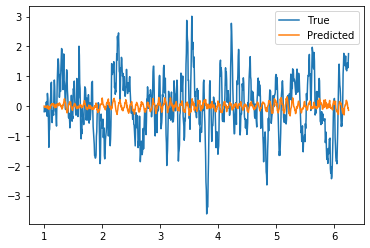

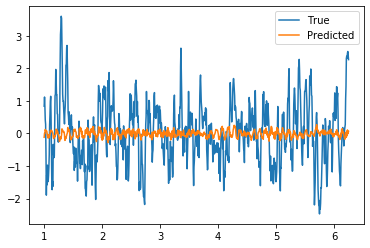

In [0]:
plot_predictions(trials_valid, valid_num)


In [0]:
#Visualise and set the best learning rate for the model 
plt.semilogx(history.history[“lr”], history.history[“loss”])
plt.axis([1e-8, 1e-4, 0, 30])

SyntaxError: ignored

In [0]:
score = model.evaluate(test_X, test_Y)
print("Test Loss:", score[0])


In [0]:
#Graphical Display to plot weights
def plot_weights(weights, electi):
 
        
    T = np.arange(0, 0.00625*window, 0.00625)                       # creation of the time variable (on 1s) for the abscissa
    
    nbr_elct = len(electi)
    (Lo_W, la_W) = weights[0].shape
    Lo_W = int(Lo_W)                                              # number of lines: inputs (160 * nbr_electrodes, for example)
    la_W = int(la_W)                                              # number of columns: number of neurons in the layer
    
    z=0
    while z < nbr_elct:                                           # for each electrode
        z_1=0 
        while z_1 < la_W:                                         # for each neuron of the W layer [1]
            W_tmp = tf.slice(K.constant(weights[0]), [0, z_1], [Lo_W, 1])           # slice: starting value [line 0, column of the neuron], dimensions of the section [160 * nbr_electrodes lines, 1 column])
            W_tmp = tf.slice(W_tmp, [z*window, 0], [window, 1])       # slice: starting value [first value of the new electrode, column 0], dimensions of the section [160 lines, 1 column]
            print (W_tmp.shape)
            
            plt.plot(T, K.eval(W_tmp), label= ("neurone_", z_1, "layer_1, electrode_", electi[z]))
            z_1 = z_1+1
            
        z = z+1
        
    plt.legend()    
    plt.show()
    

In [0]:
weights = np.array(model.get_weights()) #Convert the weights into np array

plot_weights(weights, electi)            #Plot the weights of the model

In [0]:
weights.shape